#Classification using XLNet on IMDB dataset

In this mini-project, we use a pre-trained neural network as XLNet to predict the sentiment of movie reviews extracted from a large dataset before and after performing data augmentation.

Due to the deluge of unstructured data produced nowadays like in text messages, social media, forums, blogs, news publishing platforms, web searches, and many other channels, it is imperative to develop efficient NLP algorithms to handle such a large volume of text data.

Over the last decade, NLP technology has seen an incredible leap, with much progress made by Deep Learning. Started by Word2Vec the breakthroughs within the domain are numerous and made possible the creation (or revamp) of applications like machine translation, speech recognition, chatbots, and so on.

For this task, we will use various Python libraries to perform data wrangling, exploratory analysis, model building, training, and evaluation.

## 1.Data gathering

We start by gathering the movie reviews from raw text files made available from Stanford AI Lab at this [link](https://ai.stanford.edu/~amaas/data/sentiment/).

The text files names follow a convention: [id]_[rating].txt where [id] is a unique id and [rating] is the star rating for that review on a 1-10 scale.

In the labeled _Train_/_Test_ subsets, a **negative** review has a score <= 4 out of 10,
and a **positive** review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included.

Here, we will extract the review information from each file name and assign a label accordingly.

In [ ]:
# Mount a virtual drive from GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

# Create a list object to import positive reviews from train directory
file_names_pos = os.listdir('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/train/pos/')

# Create dataframe to store scores, labels, and texts
train_pos = pd.DataFrame(columns=['text', 'score','label'])

for i in range(0,len(file_names_pos)):
  ending = file_names_pos[i].split('_')[-1]
  res = [int(i) for i in ending.split('.') if i.isdigit()]
  train_pos.loc[i,'score'] = res[0]
  train_pos.loc[i,'label'] = 'positive'
  with open('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/train/pos/' + file_names_pos[i], "r") as pos_file:
    train_pos.loc[i,'text'] = pos_file.read()
        
# Create a list object to import negative reviews from train directory
file_names_neg = os.listdir('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/train/neg/')

# Create dataframe to store scores, labels, and texts
train_neg = pd.DataFrame(columns=['text', 'score','label'])

for i in range(0,len(file_names_neg)):
  ending = file_names_neg[i].split('_')[-1]
  res = [int(i) for i in ending.split('.') if i.isdigit()]
  train_neg.loc[i,'score'] = res[0]
  train_neg.loc[i,'label'] = 'negative'
  with open('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/train/neg/' + file_names_neg[i], "r") as neg_file:
    train_neg.loc[i,'text'] = neg_file.read()

# Concatenate both positive and negative reviews dataframes
df_train = pd.concat([train_pos,train_neg], ignore_index=True)
df_train.head() # display the first 5 rows

,text,score,label
0,Nicely and intelligently played by the two you...,10,positive
1,S.S. Van Dine must have been a shrewd business...,8,positive
2,EDMUND LOWE (who reminds me somewhat of Warren...,7,positive
3,When Philo Vance (Edmund Lowe) is standing pre...,9,positive
4,Etienne Girardot is just a character actor--th...,7,positive


In [ ]:
# Create a list object to import positive reviews from test directory
file_names_pos = os.listdir('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/test/pos/')

# Create dataframe to store scores, labels, and texts
test_pos = pd.DataFrame(columns=['text', 'score','label'])

for i in range(0,len(file_names_pos)):
  ending = file_names_pos[i].split('_')[-1]
  res = [int(i) for i in ending.split('.') if i.isdigit()]
  test_pos.loc[i,'score'] = res[0]
  test_pos.loc[i,'label'] = 'positive'
  with open('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/test/pos/' + file_names_pos[i], "r") as pos_file:
    test_pos.loc[i,'text'] = pos_file.read()
        
# Create a list object to import negative reviews from test directory
file_names_neg = os.listdir('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/test/neg/')

# Create dataframe to store scores, labels, and texts
test_neg = pd.DataFrame(columns=['text', 'score','label'])

for i in range(0,len(file_names_neg)):
  ending = file_names_neg[i].split('_')[-1]
  res = [int(i) for i in ending.split('.') if i.isdigit()]
  test_neg.loc[i,'score'] = res[0]
  test_neg.loc[i,'label'] = 'negative'
  with open('/content/drive/My Drive/data/aclImdb_v1.tar.gz/aclImdb/test/neg/' + file_names_neg[i], "r") as neg_file:
    test_neg.loc[i,'text'] = neg_file.read()

# Concatenate both positive and negative reviews dataframes
df_test = pd.concat([test_pos,test_neg], ignore_index=True)
df_test.head() # display the first 5 rows

,text,score,label
0,Simon Wests pg-13 thriller about a babysitter ...,7,positive
1,I was recently at a sleepover birthday party w...,9,positive
2,A hundred miles away from the scene of a grizz...,7,positive
3,If you have ever babysat in a house you didn't...,7,positive
4,People say that this film is a 'typical teen h...,8,positive


## 2. Exploratory Analysis

Before start is always a good practice to understand the data. So, let's do some exploratory data analysis;

In [ ]:
# Get preliminaries from dataset
df_train.describe()

,text,score,label
count,25000,25000,25000
unique,24904,8,2
top,This show comes up with interesting locations ...,1,negative
freq,3,5100,12500


As we see, the _Train_ subset has 25,000 rows. However, not all of them are unique, that means, there are some duplicates that we need to deal with.

In [ ]:
# Display duplicates
duplicated = df_train[df_train.duplicated(keep=False)]
duplicated.sort_values("text")

,text,score,label
21217,'Dead Letter Office' is a low-budget film abou...,4,negative
23936,'Dead Letter Office' is a low-budget film abou...,4,negative
6591,".......Playing Kaddiddlehopper, Col San Fernan...",8,positive
3741,".......Playing Kaddiddlehopper, Col San Fernan...",8,positive
18177,"<br /><br />Back in his youth, the old man had...",2,negative
...,...,...,...
17877,"in this movie, joe pesci slams dunks a basketb...",3,negative
3123,it's amazing that so many people that i know h...,9,positive
3126,it's amazing that so many people that i know h...,9,positive
20027,this movie begins with an ordinary funeral... ...,1,negative


In [ ]:
# Drop the duplicates
df_train = pd.DataFrame.drop_duplicates(df_train, ignore_index=True)
df_train.shape

(24905, 3)

From 25,000 rows 24,905 were left. Let's check again for uniquiness.

In [ ]:
# Check the result
df_train.describe()

,text,score,label
count,24905,24905,24905
unique,24904,8,2
top,"Sondra Locke stinks in this film, but then she...",1,positive
freq,2,5068,12472


Still a problem. There is an issue with the row with text about _Sondra Locke's_ film. Let's investigate.

In [ ]:
# Display rows with the same text about Sondra Locke
df_train[df_train['text'].str.contains("Sondra Locke stinks in this film, but then she")]

,text,score,label
13436,"Sondra Locke stinks in this film, but then she...",3,negative
13438,"Sondra Locke stinks in this film, but then she...",4,negative


The previous cleaning method didn't catch this issue because it did not considered those rows as duplicates since the scores are different. Let's handle that.

In [ ]:
# Drop the duplicate
df_train = df_train.drop(df_train.index[13438])

In [ ]:
# Check the result
df_train.describe()

,text,score,label
count,24904,24904,24904
unique,24904,8,2
top,I'm certainly glad that a film was made about ...,1,positive
freq,1,5068,12472


We are good to go. Now, let's check for the distribution of _scores_ and _labels_. But first we need to check on each column data type.

In [ ]:
# Check columns data type
df_train.dtypes

text     object
score    object
label    object
dtype: object

Before plotting we need to convert each column values accordingly.

In [ ]:
df_train['score'] = df_train['score'].astype(int) # convert into integers
df_train['label'] = pd.Categorical(df_train.label) # convert into categorical

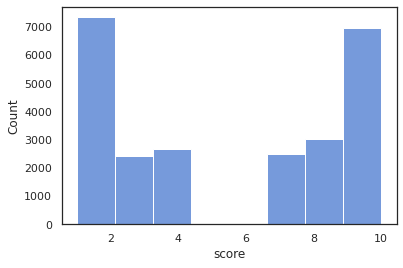

In [ ]:
import seaborn as sns

sns.set(color_codes=True)
sns.set(style="white", palette="muted")

# Plot histogram of the scores
score =sns.histplot(data=df_train, x="score", bins=8)

The graph above is pratically symmetric with no values between 5 and 6 (as previously noted) which indicates that the distribuition of negatives and positive labels may be uniform. Let's check.

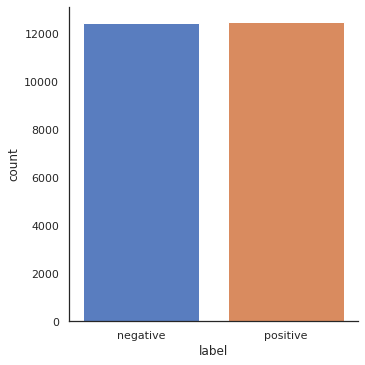

In [ ]:
# Print labels bar plor
label = sns.catplot(x="label", kind="count", data=df_train)

As we can verify from the graph above, the labels are not significantly imbalanced and we do not have to worry about doing under(over)sampling or creating synthetic data.

Let's do a similar check on _Test_ subset.

In [ ]:
# Get preliminaries from datases
df_test.describe()

,text,score,label
count,25000,25000,25000
unique,24801,8,2
top,Loved today's show!!! It was a variety and not...,1,positive
freq,5,5022,12500


There are also issues with duplicated rows. Now that we are aware, we will not  remove duplicates considering all columns values but only _text_ duplicates.

In [ ]:
# Remove row duplicates based on text
df_test = df_test.drop_duplicates(subset=['text'])

In [ ]:
# Check the result
df_test.describe()

,text,score,label
count,24801,24801,24801
unique,24801,8,2
top,The first thing I noticed about this movie was...,10,positive
freq,1,4965,12440


In [ ]:
df_test['score'] = df_test['score'].astype(int) # convert into integers
df_test['label'] = pd.Categorical(df_test.label) # convert into categorical

In [ ]:
# Count labels for each category
df_test['label'].value_counts()

positive    12440
negative    12361
Name: label, dtype: int64

## 2. Data Pre-processing

In every NLP task it is necessary to perform some pre-processing on data, like removing some characters from text that do not bring much information  like urls, tags, accents, emoticons, and stop words. Sometimes it is desirable to go for words' decapitalization and use word stems.

In [ ]:
import re

# Define a function to remove unecessary characters from the text
def clean_text(text):
    # text = text.lower() #lower case
    text = re.sub(r"<[^>]*>", ' ', text)
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
    text = re.sub('\t', ' ',  text)
    text = re.sub(r" +", ' ', text)
    return text

In [ ]:
# Apply the clean_text function of both data sets
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)
df_train.head() # display the first 5 rows of Train subset

,text,score,label
0,Nicely and intelligently played by the two you...,10,positive
1,S.S. Van Dine must have been a shrewd business...,8,positive
2,EDMUND LOWE who reminds me somewhat of Warren ...,7,positive
3,When Philo Vance Edmund Lowe is standing preca...,9,positive
4,Etienne Girardot is just a character actor the...,7,positive


Now we will replace the categorical values of the labels by numbers, that means, positive = 1, and negative = 0.

In [ ]:
# Replace labels with numbers on both subsets
df_train['label'] = df_train['label'].map({'positive':1, 'negative':0})
df_test['label'] = df_test['label'].map({'positive':1, 'negative':0})
df_test.head() # display the first 5 rows of Test subset

,text,score,label
0,Simon Wests pg 13 thriller about a babysitter ...,7,1
1,I was recently at a sleepover birthday party w...,9,1
2,A hundred miles away from the scene of a grizz...,7,1
3,If you have ever babysat in a house you didn't...,7,1
4,People say that this film is a 'typical teen h...,8,1


## 3. Modeling

Now we are ready to build a model, train, and test it.

In [ ]:
!pip3 install -q tensorflow_gpu #==2.1.0

     |████████████████████████████████| 320.4MB 56kB/s 


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [ ]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3MB 30.8MB/s 
     |████████████████████████████████| 983kB 48.6MB/s 
     |████████████████████████████████| 266kB 53.8MB/s 
     |████████████████████████████████| 1.3MB 47.5MB/s 
     |████████████████████████████████| 1.1MB 54.4MB/s 
     |████████████████████████████████| 471kB 46.4MB/s 
     |████████████████████████████████| 2.9MB 52.8MB/s 
     |████████████████████████████████| 890kB 51.5MB/s 
ERROR: transformers 3.5.1 has requirement sentencepiece==0.1.91, but you'll have sentencepiece 0.1.94 which is incompatible.


It is imperative to shuffle rows since we concatenated positive observations on top of negative ones.

In [ ]:
from sklearn.utils import shuffle

# Shuffle rows
df_train = shuffle(df_train)
df_test = shuffle(df_test)

Models based on Transformers like XLNet consume lots of computational resources. Even using a GPU it would take a significant amount of time to train and validade the model. That is why we decided to reduce the number of rows.



In [ ]:
# Reduce number of rows
df_train = df_train[:12000]
df_test = df_test[:12000]

In [ ]:
# Get Train and Test features and labels
X_train = df_train.text; X_test = df_test.text; y_train = df_train.label; y_test = df_test.label

# Transform from series into lists/arrays
X_train = X_train.tolist()
X_test = X_test.tolist()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

In [ ]:
# Check size of Train and Test subsets
len(X_train), len(X_test)

(12000, 12000)

Now we are ready to build the model.

In [ ]:
import ktrain
from ktrain import text

# Create Transformer model
MODEL_NAME = 'xlnet-base-cased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=['positive','negative'])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: en
train sequence lengths:
	mean : 235
	95percentile : 598
	99percentile : 894


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 229
	95percentile : 577
	99percentile : 889


### 3.1 Model training

Before training the model it is interesting to estimate a proper learning rate. This will save time on training and help optimization algorithm to converge.


simulating training for different learning rates... this may take a few moments...
Epoch 1/2
2000/2000 [==============================] - 3299s 2s/step - loss: 0.4957 - accuracy: 0.7337
Epoch 2/2
2000/2000 [==============================] - 3273s 2s/step - loss: 4.9734 - accuracy: 0.4987


done.
Visually inspect loss plot and select learning rate associated with falling loss


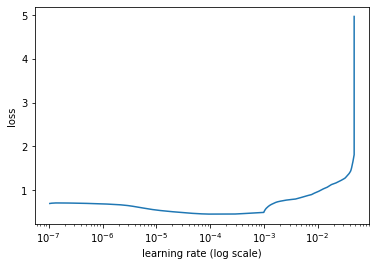

In [ ]:
# Estimate the Learning Rate
learner.lr_find(show_plot=True, max_epochs=2)

In [ ]:
# Train the model
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
2000/2000 [==============================] - 4570s 2s/step - loss: 0.2562 - accuracy: 0.9003 - val_loss: 0.2175 - val_accuracy: 0.9147
Epoch 2/4
2000/2000 [==============================] - 4569s 2s/step - loss: 0.1995 - accuracy: 0.9282 - val_loss: 0.3221 - val_accuracy: 0.8698
Epoch 3/4
2000/2000 [==============================] - 4574s 2s/step - loss: 0.1403 - accuracy: 0.9487 - val_loss: 0.1927 - val_accuracy: 0.9376
Epoch 4/4
2000/2000 [==============================] - 4575s 2s/step - loss: 0.0448 - accuracy: 0.9867 - val_loss: 0.2118 - val_accuracy: 0.9383


### 3.2 Evaluate and Inspect the Model

We can now evaluate the model on _Test_ subset.

In [ ]:
learner.validate(class_names=t.get_classes())


              precision    recall  f1-score   support

    positive       0.94      0.94      0.94      6046
    negative       0.93      0.94      0.94      5954

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



array([[5654,  392],
       [ 349, 5605]])

As we can see the accuracy was quite good, i.e., 94%. Of course, there is room for improvement since the best score using this dataset is 99.2% (check [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/leaderboard)).

Let's inspect the wrongest prediction.

In [ ]:
# Check on the prediction with the highest loss
learner.view_top_losses(n=1, preproc=t)

----------
id:4979 | loss:7.24 | true:negative | pred:positive)



In [ ]:
print(X_test[4979])

Basically an endearingly chintzy and moronic 1.50 version of the nifty early 80's subterranean creature feature favorite The Boogens this entertainingly schlocky cheapie centers on a nasty squirmy wriggling monster who makes an instant meal out of any unfortunate souls foolhardy enough to go poking around the notoriously off limits Gold Spike Mine. Your standard issue motley assortment of intrepid boneheads hectoring hard nosed mine boss cute but insipid blonde babe feisty lady geologist boozy inexplicably Aussie accented ! seasoned old mine hand charmless doofus hunky jolly guy and arguably the most annoying character of the uniformly irritating bunch a nerdy bespectacled aspiring writer dweeb who's prone to speaking in flowery melodramatic utterances trek into the dark uninviting cave in search of gold. Naturally these intensely insufferable imbeciles discover that the allegedly abandoned mine is the home of a deadly ugly multi tentacled beast who in time honored hoary B flick fashio

Now let's save the trained model.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
predictor.save('./content/drive/data/xlnet_predictor-v1_0')

### 3.3 Predict on unlabed data

The Stanford AI Lab data reposity has also unlabeled data for clustering tasks. Let's select a sample and predict its sentiment.

In [ ]:
# Predict on unlabeled review
predictor.predict("This is a very strange film that was long thought to be forgotten. It s the story of two American Army buddies, William Boyd (aka Hopalong Cassidy) and Louis Wolheim, and their adventures as they manage to escape from a German prison camp during WWI. However, as this is a comedy, the duo manage to make the most round about and stupid escape accidentally boarding a train to Constantinople to be placed in a Turkish prisoner of war camp! On the way, they manage to escape once again and end up in quite the adventure--meeting sexy Mary Astor along the way. As far as the film goes, it was a rather funny script and despite being a silly plot, it worked rather well. The chemistry between Boyd and Wolheim worked and the film managed to be quite entertaining. Oddly, however, the film managed to beat out Harold Lloyd's film, SPEEDY, for an Oscar for Best Direction for a Comedy (a category no longer used)--as SPEEDY was a superior film in most ways (it's one of Lloyd's best films). Still, it's well worth a look especially if you love silent films. By the way, director Milestone and Louis Walheim would team up just a few years later for another WWI picture, the great ALL QUIET ON THE WESTERN FRONT, a film that is definitely NOT a comedy.")

'negative'

In [ ]:
predictor.get_classes()

['positive', 'negative']

In [ ]:
# Predict probability scores for each category
predictor.predict_proba("This is a very strange film that was long thought to be forgotten. It s the story of two American Army buddies, William Boyd (aka Hopalong Cassidy) and Louis Wolheim, and their adventures as they manage to escape from a German prison camp during WWI. However, as this is a comedy, the duo manage to make the most round about and stupid escape accidentally boarding a train to Constantinople to be placed in a Turkish prisoner of war camp! On the way, they manage to escape once again and end up in quite the adventure--meeting sexy Mary Astor along the way. As far as the film goes, it was a rather funny script and despite being a silly plot, it worked rather well. The chemistry between Boyd and Wolheim worked and the film managed to be quite entertaining. Oddly, however, the film managed to beat out Harold Lloyd's film, SPEEDY, for an Oscar for Best Direction for a Comedy (a category no longer used)--as SPEEDY was a superior film in most ways (it's one of Lloyd's best films). Still, it's well worth a look especially if you love silent films. By the way, director Milestone and Louis Walheim would team up just a few years later for another WWI picture, the great ALL QUIET ON THE WESTERN FRONT, a film that is definitely NOT a comedy.")

array([0.00286736, 0.99713266], dtype=float32)

Another lengthy text with some positive comments but also negative ones. Let's see what captured the model's attention to end up on a negative classification.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
predictor.explain("This is a very strange film that was long thought to be forgotten. It s the story of two American Army buddies, William Boyd (aka Hopalong Cassidy) and Louis Wolheim, and their adventures as they manage to escape from a German prison camp during WWI. However, as this is a comedy, the duo manage to make the most round about and stupid escape accidentally boarding a train to Constantinople to be placed in a Turkish prisoner of war camp! On the way, they manage to escape once again and end up in quite the adventure--meeting sexy Mary Astor along the way. As far as the film goes, it was a rather funny script and despite being a silly plot, it worked rather well. The chemistry between Boyd and Wolheim worked and the film managed to be quite entertaining. Oddly, however, the film managed to beat out Harold Lloyd's film, SPEEDY, for an Oscar for Best Direction for a Comedy (a category no longer used)--as SPEEDY was a superior film in most ways (it's one of Lloyd's best films). Still, it's well worth a look especially if you love silent films. By the way, director Milestone and Louis Walheim would team up just a few years later for another WWI picture, the great ALL QUIET ON THE WESTERN FRONT, a film that is definitely NOT a comedy.")

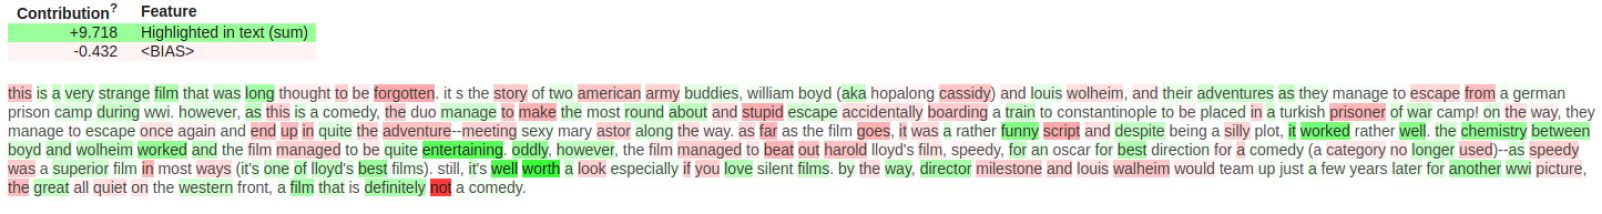

As we can see, the model perceived positive and negative words but in an unbalanced manner. Examples of negative ones like "not", "far", "forgotten", and "stupid" seemed to influence its decision.

## 4. Data Augmentation

Now let's compare the previous model with a new one. This time trained in an augmented dataset and check for accuracy. For this resort, we will use synonym replacement and expand the previous _Train_ subset by 50%.

In [ ]:
!pip install textaugment

In [ ]:
from textaugment import EDA
import nltk
nltk.download(['stopwords','wordnet'])

t = EDA(random_state=123)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Let's create a function to augment data and call it on _Train_ subset.

In [ ]:
import numpy as np

# Define a function for data augmentation
def eda(lis,arr,pct):
  for i in range(0,int(len(lis)*pct)):
    lis.append(t.synonym_replacement(lis[i])) # synonym replacement
    arr = np.append(arr,arr[i])
  return lis, arr

In [ ]:
# Increase Train subset by 50% using EDA
X_train, y_train = eda(X_train,y_train,0.5)

In [ ]:
# Check size of Train and Test subsets
len(X_train), len(X_test)

(18000, 12000)

Again, let's shuffle rows.

In [ ]:
# Shuffle rows
df_train = shuffle(df_train)
df_test = shuffle(df_test)

Time to build the model and train the new model.

In [ ]:
# Create new Transformer model
MODEL_NAME = 'xlnet-base-cased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=['positive','negative'])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: en
train sequence lengths:
	mean : 232
	95percentile : 596
	99percentile : 900


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 230
	95percentile : 588
	99percentile : 890


In [ ]:
# Train the new model
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
3000/3000 [==============================] - 6204s 2s/step - loss: 0.2137 - accuracy: 0.9175 - val_loss: 0.2045 - val_accuracy: 0.9245
Epoch 2/4
3000/3000 [==============================] - 6207s 2s/step - loss: 0.1580 - accuracy: 0.9451 - val_loss: 0.1954 - val_accuracy: 0.9287
Epoch 3/4
3000/3000 [==============================] - 6208s 2s/step - loss: 0.1095 - accuracy: 0.9628 - val_loss: 0.2296 - val_accuracy: 0.9352
Epoch 4/4
3000/3000 [==============================] - 6210s 2s/step - loss: 0.0295 - accuracy: 0.9918 - val_loss: 0.2458 - val_accuracy: 0.9376


### 4.1 Evaluate the Model

Now let's evaluate the new model on _Test_ subset.

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

    positive       0.94      0.94      0.94      6044
    negative       0.94      0.94      0.94      5956

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



array([[5665,  379],
       [ 370, 5586]])

As we can see from previous result, accuracy did not change. 

Let's inspect the wrongest prediction.

In [ ]:
# Check on the prediction with the highest loss
learner.view_top_losses(n=1, preproc=t)

----------
id:3722 | loss:7.99 | true:positive | pred:negative)



In [ ]:
print(X_test[3722])

Nice movie and Nicholle Tom does a fantastic job playing the guy in the girl's body she really does it well. A sort of teen version of many other movies but well done. Well casted from Matt to Matt2 .


"_Nice movie and Nicholle Tom does a fantastic job playing the guy in the girl's body she really does it well. A sort of teen version of many other movies but well done. Well casted from Matt to Matt2._"

Model prediction in this example is quite odd because most of the words have a  positive sentiment. Let's investigate further.

In [ ]:
predictor.get_classes()

['positive', 'negative']

In [ ]:
# Predict probability scores for each category
predictor.predict_proba(X_test[3722])

array([3.3855438e-04, 9.9966145e-01], dtype=float32)

As we see from the classes probabilities, the model computed the sentiment as _negative_ with a very high likelihood. Let's check which features contributed with that.

In [ ]:
predictor.explain(X_test[3722])

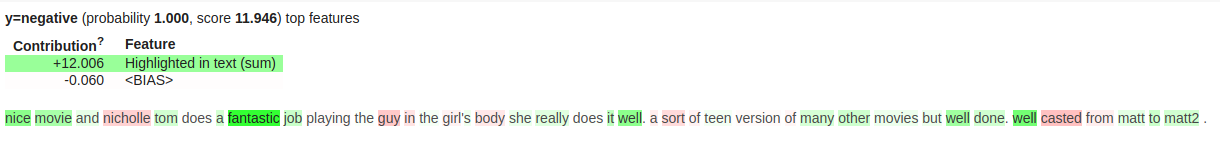

This is an interesting case since the top features are clearly mostly positive ones. However, the model classified the review as _negative_. We may be facing a weakness or bias in the model and might be investigated afterward.

## 5. Conclusion

In this mini-project, we dealt with a classification task to capture sentiment on movie text reviews. For such, It was used a known dataset made available by Standford AI Lab and composed of labeled _Train_ and _Test_ subsets with 25,000 observations each.

After performing some wrangling with the data we reduced it by half to save computational resources during training and testing. After, we augmented such data with an EDA technique, namely synonym substitution.

In end, the performance of the model did not improve (or worsened). The accuracy value itself was not too far from what are best results achieved with the same dataset and goal.